<a href="https://colab.research.google.com/github/GanesH2O/Downscale-GRACE/blob/main/01_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load necessary

## Install and import necessary packages

In [ ]:
!pip install geedim
!pip install xarray rioxarray rasterio netCDF4
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 82.7 MB/s eta 0:00:00


In [ ]:
import geedim
import geemap
import geopandas as gpd
import ee
import os
import re
import xarray as xr
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nepal_shp = gpd.read_file('/content/drive/MyDrive/Paperwork/SHP/AOI.shp')
nepal_shp = nepal_shp.set_crs('epsg:4326')
world_shp = gpd.read_file('/content/drive/MyDrive/Paperwork/SHP/world-administrative-boundaries.shp')
world_shp = world_shp.set_crs('epsg:4326')

# Download Data

In [ ]:
geemap.ee.Authenticate()
geemap.ee.Initialize(project='ee-079mswre006ashish')

In [ ]:
#Monthly CHIRPS data was downloaded from: https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalMonthlyP05.html
#G3P downloaded from: https://dataservices.gfz-potsdam.de/panmetaworks/showshort.php?id=2cd347ef-be20-11ed-95b8-f851ad6d1e4b
#NDVI and EVI downloaded from: https://appeears.earthdatacloud.nasa.gov/task/area


## Download LST and visualize

In [ ]:
# Define the Region of Interest (Modify as needed)
roi = ee.Geometry.Rectangle([77,24,89,30])  # Global bounding box

# Function to compute monthly mean GWS while preserving resolution
def get_monthly_mean(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    image = (ee.ImageCollection('projects/sat-io/open-datasets/gap-filled-lst/gf_day_1km')
             .filterBounds(roi)
             .filterDate(start_date, end_date)
             .map(lambda img: img.clip(roi))
             .mean()  # Preserves native resolution
             .select('b1')
             .set('system:time_start', start_date.millis()))

    return image

# Loop through years and months
for year in range(2003, 2021):  # 2003 to 2020
    for month in range(1, 13):  # January to December
        image_to_export = get_monthly_mean(year, month)

        # Export to Google Drive
        task = ee.batch.Export.image.toDrive(
            image=image_to_export,
            description=f'LST_DAY_{year}_{month:02d}',
            folder='LST_DAY',
            fileNamePrefix=f'LST_DAY_{year}_{month:02d}',
            region=roi.getInfo()['coordinates'],
            scale=796.8116001560662,  # Ensures native resolution (~0.8 km per pixel)
            maxPixels=1e13,
            crs='EPSG:4326'
        )

        # Start the export task
        task.start()
        print(f"Export started for {year}-{month:02d}. Check Google Earth Engine Task Manager.")

Export started for 2003-01. Check Google Earth Engine Task Manager.
Export started for 2003-02. Check Google Earth Engine Task Manager.
Export started for 2003-03. Check Google Earth Engine Task Manager.
Export started for 2003-04. Check Google Earth Engine Task Manager.
Export started for 2003-05. Check Google Earth Engine Task Manager.
Export started for 2003-06. Check Google Earth Engine Task Manager.
Export started for 2003-07. Check Google Earth Engine Task Manager.
Export started for 2003-08. Check Google Earth Engine Task Manager.
Export started for 2003-09. Check Google Earth Engine Task Manager.
Export started for 2003-10. Check Google Earth Engine Task Manager.
Export started for 2003-11. Check Google Earth Engine Task Manager.
Export started for 2003-12. Check Google Earth Engine Task Manager.
Export started for 2004-01. Check Google Earth Engine Task Manager.
Export started for 2004-02. Check Google Earth Engine Task Manager.
Export started for 2004-03. Check Google Earth E

In [ ]:
# Set the path to your Google Drive folder containing the TIFF files
folder_path = "/content/drive/MyDrive/LST_DAY"
output_nc_file = "LST_DAY.nc"

# List all .tif files in the folder
tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tif")])

# Extract time information from filenames and load images
data_list = []
time_list = []

for tif_file in tif_files:
    # Extract year and month from filename using regex
    match = re.search(r"(\d{4})_(\d{2})", tif_file)  # Matches "2003_05" in "GLDAS_GWS_2003_05.tif"
    if match:
        year, month = match.groups()
        time = pd.to_datetime(f"{year}-{month}-01")  # Convert to datetime format
        time_list.append(time)

        # Read the TIFF file as an xarray DataArray
        file_path = os.path.join(folder_path, tif_file)
        da = rxr.open_rasterio(file_path)  # Read raster
        da = da.squeeze()  # Remove extra dimensions
        da = da.rename("lst_day")  # Rename variable
        da = da.assign_coords(time=time)  # Assign time coordinate
        data_list.append(da)

# Combine all images into a single xarray Dataset along the time dimension
dataset = xr.concat(data_list, dim="time")

# Save to NetCDF
dataset.to_netcdf(f"/content/drive/MyDrive/Paperwork/DATA/{output_nc_file}")

print(f"NetCDF file saved as: {output_nc_file}")

NetCDF file saved as: LST_DAY.nc


In [ ]:
lst_d = xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/LST_DAY.nc')
lst_d = lst_d.drop_vars('spatial_ref')
print(lst_d.variables)

Frozen({'band': <xarray.Variable ()> Size: 8B
[1 values with dtype=int64], 'x': <xarray.IndexVariable 'x' (x: 1677)> Size: 13kB
array([77.000898, 77.008056, 77.015214, ..., 88.98319 , 88.990348, 88.997506]), 'y': <xarray.IndexVariable 'y' (y: 859)> Size: 7kB
array([30.138255, 30.131098, 30.12394 , ..., 24.01111 , 24.003952, 23.996794]), 'time': <xarray.IndexVariable 'time' (time: 216)> Size: 2kB
array(['2003-01-01T00:00:00.000000000', '2003-02-01T00:00:00.000000000',
       '2003-03-01T00:00:00.000000000', ..., '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]'), 'lst_day': <xarray.Variable (time: 216, y: 859, x: 1677)> Size: 2GB
[311157288 values with dtype=float64]
Attributes:
    AREA_OR_POINT:  Area
    long_name:      b1
    grid_mapping:   spatial_ref})


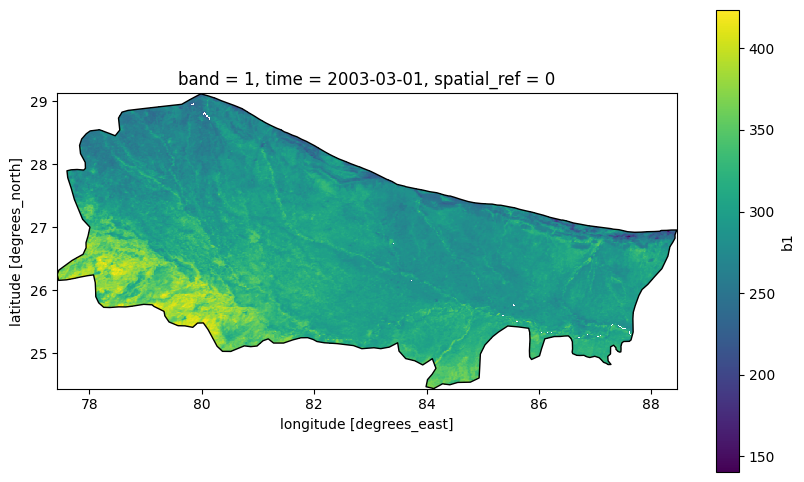

In [ ]:
lst_d = lst_d.rio.write_crs('epsg:4326')
lst_d = lst_d.rio.clip(nepal_shp.geometry,all_touched=True)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose the dataset to switch lat (y) and lon (x)
lst_dTR = lst_d.lst_day.isel(time=2).transpose('y', 'x')
lst_dTR.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
# Define the Region of Interest (Modify as needed)
roi = ee.Geometry.Rectangle([77,24,89,30])  # Global bounding box

# Function to compute monthly mean GWS while preserving resolution
def get_monthly_mean(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    image = (ee.ImageCollection('projects/sat-io/open-datasets/gap-filled-lst/gf_night_1km')
             .filterBounds(roi)
             .filterDate(start_date, end_date)
             .map(lambda img: img.clip(roi))
             .mean()  # Preserves native resolution
             .select('b1')
             .set('system:time_start', start_date.millis()))

    return image

# Loop through years and months
for year in range(2003, 2021):  # 2003 to 2020
    for month in range(1, 13):  # January to December
        image_to_export = get_monthly_mean(year, month)

        # Export to Google Drive
        task = ee.batch.Export.image.toDrive(
            image=image_to_export,
            description=f'LST_NIGHT_{year}_{month:02d}',
            folder='LST_NIGHT',
            fileNamePrefix=f'LST_NIGHT_{year}_{month:02d}',
            region=roi.getInfo()['coordinates'],
            scale=796.8116001560662,  # Ensures native resolution (~0.8 km per pixel)
            maxPixels=1e13,
            crs='EPSG:4326'
        )

        # Start the export task
        task.start()
        print(f"Export started for {year}-{month:02d}. Check Google Earth Engine Task Manager.")

Export started for 2003-01. Check Google Earth Engine Task Manager.
Export started for 2003-02. Check Google Earth Engine Task Manager.
Export started for 2003-03. Check Google Earth Engine Task Manager.
Export started for 2003-04. Check Google Earth Engine Task Manager.
Export started for 2003-05. Check Google Earth Engine Task Manager.
Export started for 2003-06. Check Google Earth Engine Task Manager.
Export started for 2003-07. Check Google Earth Engine Task Manager.
Export started for 2003-08. Check Google Earth Engine Task Manager.
Export started for 2003-09. Check Google Earth Engine Task Manager.
Export started for 2003-10. Check Google Earth Engine Task Manager.
Export started for 2003-11. Check Google Earth Engine Task Manager.
Export started for 2003-12. Check Google Earth Engine Task Manager.
Export started for 2004-01. Check Google Earth Engine Task Manager.
Export started for 2004-02. Check Google Earth Engine Task Manager.
Export started for 2004-03. Check Google Earth E

In [ ]:
# Set the path to your Google Drive folder containing the TIFF files
folder_path = "/content/drive/MyDrive/LST_NIGHT"
output_nc_file = "LST_NIGHT.nc"

# List all .tif files in the folder
tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tif")])

# Extract time information from filenames and load images
data_list = []
time_list = []

for tif_file in tif_files:
    # Extract year and month from filename using regex
    match = re.search(r"(\d{4})_(\d{2})", tif_file)  # Matches "2003_05" in "GLDAS_GWS_2003_05.tif"
    if match:
        year, month = match.groups()
        time = pd.to_datetime(f"{year}-{month}-01")  # Convert to datetime format
        time_list.append(time)

        # Read the TIFF file as an xarray DataArray
        file_path = os.path.join(folder_path, tif_file)
        da = rxr.open_rasterio(file_path)  # Read raster
        da = da.squeeze()  # Remove extra dimensions
        da = da.rename("lst_night")  # Rename variable
        da = da.assign_coords(time=time)  # Assign time coordinate
        data_list.append(da)

# Combine all images into a single xarray Dataset along the time dimension
dataset = xr.concat(data_list, dim="time")

# Save to NetCDF
dataset.to_netcdf(f"/content/drive/MyDrive/Paperwork/DATA/{output_nc_file}")

print(f"NetCDF file saved as: {output_nc_file}")

NetCDF file saved as: LST_NIGHT.nc


In [ ]:
lst_n = xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/LST_NIGHT.nc')
lst_n = lst_n.drop_vars('spatial_ref')
print(lst_d.variables)

Frozen({'band': <xarray.Variable ()> Size: 8B
[1 values with dtype=int64], 'x': <xarray.IndexVariable 'x' (x: 1541)> Size: 12kB
array([77.430371, 77.437529, 77.444687, ..., 88.439191, 88.446349, 88.453507])
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east, 'y': <xarray.IndexVariable 'y' (y: 655)> Size: 5kB
array([29.121836, 29.114678, 29.107521, ..., 24.454898, 24.44774 , 24.440583])
Attributes:
    axis:           Y
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north, 'time': <xarray.IndexVariable 'time' (time: 216)> Size: 2kB
array(['2003-01-01T00:00:00.000000000', '2003-02-01T00:00:00.000000000',
       '2003-03-01T00:00:00.000000000', ..., '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]'), 'spatial_ref': <xarray.Variable ()> Size: 8B
array(0)
Attributes:
    crs_wkt:              

In [ ]:
import xarray as xr
import os

# Define the paths to your two NetCDF files
file_path_1 = '/content/drive/MyDrive/Paperwork/DATA/LST_DAY.nc'
file_path_2 = '/content/drive/MyDrive/Paperwork/DATA/LST_NIGHT.nc'

# Define the output path for the merged NetCDF file
output_merged_file = '/content/drive/MyDrive/Paperwork/DATA/LST.nc'

# Check if input files exist
if not os.path.exists(file_path_1):
    print(f"Error: File not found at {file_path_1}")
elif not os.path.exists(file_path_2):
    print(f"Error: File not found at {file_path_2}")
else:
    # Open the two NetCDF datasets
    ds1 = xr.open_dataset(file_path_1)
    ds2 = xr.open_dataset(file_path_2)
    try:
        merged_dataset = xr.merge([ds1, ds2])

        # Save the merged dataset to a new NetCDF file
        merged_dataset.to_netcdf(output_merged_file)

        print(f"Successfully merged {file_path_1} and {file_path_2} into {output_merged_file}")

        # Optional: Close the datasets to free up memory
        ds1.close()
        ds2.close()
        merged_dataset.close()

    except xr.MergeError as e:
        print(f"Error merging datasets: {e}")
        print("Ensure that the datasets have compatible dimensions and coordinates for merging.")
        # Optional: Print variables and dimensions of both datasets to help debug
        # print("Variables in ds1:", ds1.variables)
        # print("Variables in ds2:", ds2.variables)
        # print("Dimensions of ds1:", ds1.dims)
        # print("Dimensions of ds2:", ds2.dims)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Successfully merged /content/drive/MyDrive/Paperwork/DATA/LST_DAY.nc and /content/drive/MyDrive/Paperwork/DATA/LST_NIGHT.nc into /content/drive/MyDrive/Paperwork/DATA/LST.nc


## Landscan Population

### Download

In [ ]:
import ee

# Define the Region of Interest (Modify as needed)
roi = ee.Geometry.Rectangle([77, 24, 89, 30])  # Global bounding box

# Function to get yearly LANDSCAN image
def get_yearly_image(year):
    start_date = ee.Date.fromYMD(year, 1, 1)  # Start of the year
    end_date = start_date.advance(1, 'year')  # End of the year

    image = (ee.ImageCollection('projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL')
             .filterBounds(roi)
             .filterDate(start_date, end_date)
             .first()  # Get the first (and likely only) image for the year
             .clip(roi)  # Clip to the ROI
             .select('b1')
             .set('system:time_start', start_date.millis()))

    return image

# Loop through years
for year in range(2021, 2024):
    image_to_export = get_yearly_image(year)

    # Export to Google Drive
    task = ee.batch.Export.image.toDrive(
        image=image_to_export,
        description=f'LANDSCAN_{year}',
        folder='GEE_Exports_2',
        fileNamePrefix=f'LANDSCAN_{year}',
        region=roi.getInfo()['coordinates'],
        scale=927.662423277276,  # Adjust scale as needed
        maxPixels=1e13,
        crs='EPSG:4326'
    )

    # Start the export task
    task.start()
    print(f"Export started for {year}. Check Google Earth Engine Task Manager.")

### Combine

In [ ]:
# Set the path to your Google Drive folder containing the TIFF files
folder_path = "/content/drive/MyDrive/GEE_Exports_2"  # Update with your path
output_nc_file = "LANDSCAN_combined_interpolated.nc"

# List all .tif files in the folder
tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tif")])

# Extract time information from filenames and load images
data_list = []
time_list = []

for tif_file in tif_files:
    # Extract year from filename using regex
    match = re.search(r"(\d{4})", tif_file)  # Matches "2003" in "LANDSCAN_2003.tif"
    if match:
        year = int(match.groups()[0])
        time = pd.to_datetime(f"{year}-01-01")  # Convert to datetime format
        time_list.append(time)

        # Read the TIFF file as an xarray DataArray
        file_path = os.path.join(folder_path, tif_file)
        da = rxr.open_rasterio(file_path)  # Read raster
        da = da.squeeze()  # Remove extra dimensions
        da = da.rename("population")  # Rename variable
        da = da.assign_coords(time=time)  # Assign time coordinate
        data_list.append(da)

# Combine all images into a single xarray Dataset along the time dimension
dataset = xr.concat(data_list, dim="time")
dataset

### Interpolate for monthly and export

In [ ]:
# Create a new time coordinate for monthly data
time_monthly = pd.date_range(start=time_list[0], end=time_list[-1], freq='MS')

# Interpolate population data using spline interpolation
dataset_interp = dataset.interp(time=time_monthly, method='linear')
dataset_interp
dataset_interp = dataset_interp.round().astype(int)
dataset_interp = dataset_interp.rio.write_crs("EPSG:4326", inplace=True)
dataset_interp.to_netcdf(f"/content/drive/MyDrive/Thesis/RAW/LANDSCAN_combined_interpolated.nc")

# 2. Training Data

## G3P

In [ ]:
GP = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/gwsa_g3p_200204_202309_monthly_05_degree_250km_gauss_filtered_gravis.nc')
      .rename({'lat': 'y', 'lon': 'x'})
      .sortby('y')
      .rio.write_crs('epsg:4326')
      .sel(time=slice('2003-01-01', '2020-12-31'))
      .rio.clip(nepal_shp.geometry, all_touched=True)
      .drop_vars('spatial_ref'))
GP

<xarray.Dataset> Size: 750kB
Dimensions:      (time: 185, x: 23, y: 11)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2003-01-16 2003-02-16 ... 2020-12-16
  * x            (x) float32 92B 77.25 77.75 78.25 78.75 ... 87.25 87.75 88.25
  * y            (y) float32 44B 24.25 24.75 25.25 25.75 ... 28.25 28.75 29.25
Data variables:
    gwsa         (time, y, x) float64 374kB nan nan nan nan ... nan nan nan nan
    uncertainty  (time, y, x) float64 374kB nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.8
    source:       GWSA obtained from subtraction of observational (Gaussian) ...
    institution:  GFZ German Research Centre for Geosciences https://www.gfz-...
    title:        This product is assigned as the version V1.12 of groundwate...
    contact:      andreas.guentner@gfz-potsdam.de and ehsan.sharifi@gfz-potsd...
    funding:      This project has received funding from the European Union’s...
    version:      V1.12
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    history:      created 18/06/2024

In [ ]:
# Define the expected date range (including all months)
expected_start_date = '2003-01-01'
expected_end_date = '2020-12-31'
GP['time'] = pd.to_datetime(GP.time.dt.year.astype(str) + '-' + GP.time.dt.month.astype(str) + '-01')
# Create a full monthly date range for the expected period
full_time_index = pd.date_range(start=expected_start_date, end=expected_end_date, freq='MS') # 'MS' for Month Start frequency

# Reindex the dataset along the 'time' dimension
GP_full = GP.reindex(time=full_time_index)

# You can verify the number of time steps now matches the expected number
print(f"Number of time steps in original dataset: {len(GP.time)}")
print(f"Number of time steps in reindexed dataset: {len(GP_full.time)}")

Number of time steps in original dataset: 185
Number of time steps in reindexed dataset: 216


In [ ]:
# Define the output path for the NetCDF file
output_nc_file_path = '/content/drive/MyDrive/Paperwork/DATA/G3S_gwsa_full.nc'

# Export the GP_full dataset to a NetCDF file
try:
    GP_full.to_netcdf(output_nc_file_path)
    print(f"Successfully exported GP_full to {output_nc_file_path}")
except Exception as e:
    print(f"Error exporting GP_full to NetCDF: {e}")

Successfully exported GP_full to /content/drive/MyDrive/Paperwork/DATA/G3S_gwsa_full.nc


In [ ]:
df_gp = GP_full['gwsa'].to_dataframe().reset_index()
df_gp_sorted = df_gp.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/TRAINING/GWSA.csv'
df_gp_sorted.to_csv(output_csv_path, index=False)
df_gp_sorted

,time,y,x,gwsa
0,2003-01-01,24.25,77.25,NaN
23,2003-01-01,24.75,77.25,NaN
46,2003-01-01,25.25,77.25,NaN
69,2003-01-01,25.75,77.25,NaN
92,2003-01-01,26.25,77.25,146.796998
...,...,...,...,...
54555,2020-12-01,27.25,88.25,NaN
54578,2020-12-01,27.75,88.25,NaN
54601,2020-12-01,28.25,88.25,NaN
54624,2020-12-01,28.75,88.25,NaN


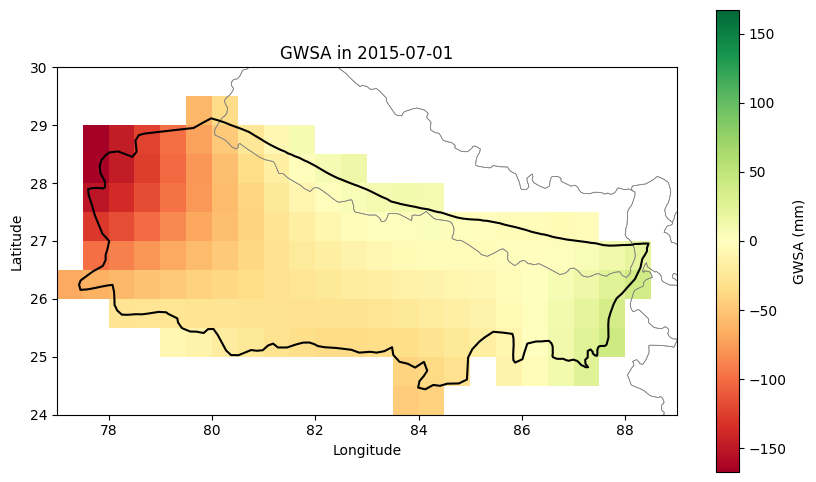

In [ ]:
# Assuming GP and nepal_shp are already loaded and processed
GP = GP_full.rio.write_crs('epsg:4326')
GP = GP.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 150
time_stamp = GP.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the GP gwsaitation data for the selected time
GPTR = GP.gwsa.isel(time=t).transpose('y', 'x')
GPTR.plot(ax=ax, cmap='RdYlGn', add_colorbar=True, cbar_kwargs={'label': 'GWSA (mm)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'GWSA in {time_str}')

plt.show()

## IMERG

In [ ]:
IMERG = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/0.25/IMERG 0.25.nc')
          .rename({'lat': 'y', 'lon': 'x'})
          .rio.write_crs('epsg:4326')
          .sel(time=slice('2003-01-01', '2020-12-31')))
IMERG

<xarray.Dataset> Size: 998kB
Dimensions:        (time: 216, x: 48, y: 24)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2003-01-01 ... 2020-12-01
  * x              (x) float64 384B 77.12 77.38 77.62 ... 88.38 88.62 88.88
  * y              (y) float64 192B 24.12 24.38 24.62 ... 29.38 29.62 29.88
    spatial_ref    int64 8B 0
Data variables:
    precipitation  (time, x, y) float32 995kB ...
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/07...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=7e;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20020901-S000...
    history_L34RS:                          'Created by L34RS v1.4.4 @ NASA G...
    CDO:                                    Climate Data Operators version 1....

In [ ]:
regrid_lat = np.arange(24.25, 29.75, 0.5)
regrid_lon = np.arange(77.25, 88.75, 0.5)
IMERG_25 = IMERG.interp(x=regrid_lon, y=regrid_lat, method='slinear')

In [ ]:
# Define the output path for the NetCDF file
output_nc_file_path = '/content/drive/MyDrive/Paperwork/DATA/0.5/IMERG_0.5.nc'

# Export the IMERG_25 dataset to a NetCDF file
try:
    IMERG_25.to_netcdf(output_nc_file_path)
    print(f"Successfully exported IMERG_25 to {output_nc_file_path}")
except Exception as e:
    print(f"Error exporting IMERG_25 to NetCDF: {e}")

Successfully exported IMERG_25 to /content/drive/MyDrive/Paperwork/DATA/0.5/IMERG_0.5.nc


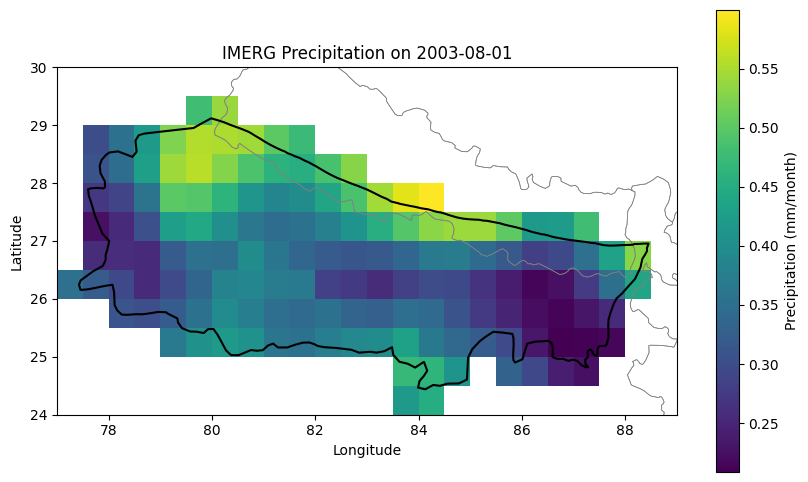

In [ ]:
# Assuming IMERG and nepal_shp are already loaded and processed
IMERG = IMERG_25.rio.write_crs('epsg:4326')
IMERG = IMERG.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = IMERG.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the IMERG precipitation data for the selected time
IMERGTR = IMERG.precipitation.isel(time=t).transpose('y', 'x')
IMERGTR.plot(ax=ax, cmap='viridis', add_colorbar=True, cbar_kwargs={'label': 'Precipitation (mm/month)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'IMERG Precipitation on {time_str}')

plt.show()

In [ ]:
IMERG_25 = IMERG.drop_vars('spatial_ref')
df_pr = IMERG_25['precipitation'].to_dataframe().reset_index()
df_pr = df_pr.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/IMERG.csv'
df_pr.to_csv(output_csv_path, index=False)
df_pr

,time,x,y,precipitation
0,2003-01-01,77.25,24.25,NaN
1,2003-01-01,77.25,24.75,NaN
2,2003-01-01,77.25,25.25,NaN
3,2003-01-01,77.25,25.75,NaN
4,2003-01-01,77.25,26.25,0.02228
...,...,...,...,...
54643,2020-12-01,88.25,27.25,NaN
54644,2020-12-01,88.25,27.75,NaN
54645,2020-12-01,88.25,28.25,NaN
54646,2020-12-01,88.25,28.75,NaN


## Precipitation (CHIRPS)

In [ ]:
CHIRPS = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/CHIRPS.nc')
          .rename({'latitude': 'y', 'longitude': 'x'})
          .rio.write_crs('epsg:4326')
          .sel(time=slice('2003-01-01', '2020-12-31')))
CHIRPS

<xarray.Dataset> Size: 25MB
Dimensions:      (time: 216, y: 121, x: 241)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
  * y            (y) float32 484B 24.02 24.07 24.12 24.17 ... 29.92 29.97 30.02
  * x            (x) float32 964B 77.02 77.08 77.12 77.17 ... 88.92 88.98 89.02
    spatial_ref  int64 8B 0
Data variables:
    precip       (time, y, x) float32 25MB ...
Attributes: (12/31)
    acknowledgements:          The Climate Hazards Group InfraRed Precipitati...
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             pete@geog.ucsb.edu
    creator_name:              Pete Peterson
    creator_type:              person
    ...                        ...
    summary:                   This dataset has monthly averages of the Clima...
    time_coverage_end:         2021-01-01T00:00:00Z
    time_coverage_start:       2000-01-01T00:00:00Z
    title:                     CHIRPS Version 2.0, Precipitation, Global, 0.0...
    version:                   2.0
    Westernmost_Easting:       77.024994

<ipython-input-59-1b252c505be7>:2: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  CHIRPS = CHIRPS.rio.set_crs('epsg:4326')


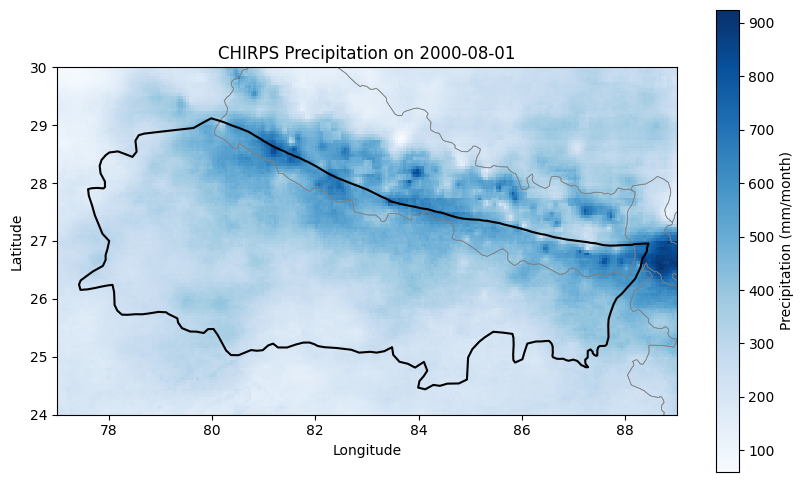

In [ ]:
# Assuming CHIRPS and nepal_shp are already loaded and processed
CHIRPS = CHIRPS.rio.set_crs('epsg:4326')
#CHIRPS = CHIRPS.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = CHIRPS.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the CHIRPS precipitation data for the selected time
CHIRPSTR = CHIRPS.precip.isel(time=t).transpose('y', 'x')
CHIRPSTR.plot(ax=ax, cmap='Blues', add_colorbar=True, cbar_kwargs={'label': 'Precipitation (mm/month)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'CHIRPS Precipitation on {time_str}')

plt.show()

In [ ]:
regrid_lat = np.arange(24.25, 29.75, 0.5)
regrid_lon = np.arange(77.25, 88.75, 0.5)
CHIRPS_25 = CHIRPS.interp(x=regrid_lon, y=regrid_lat, method='slinear')

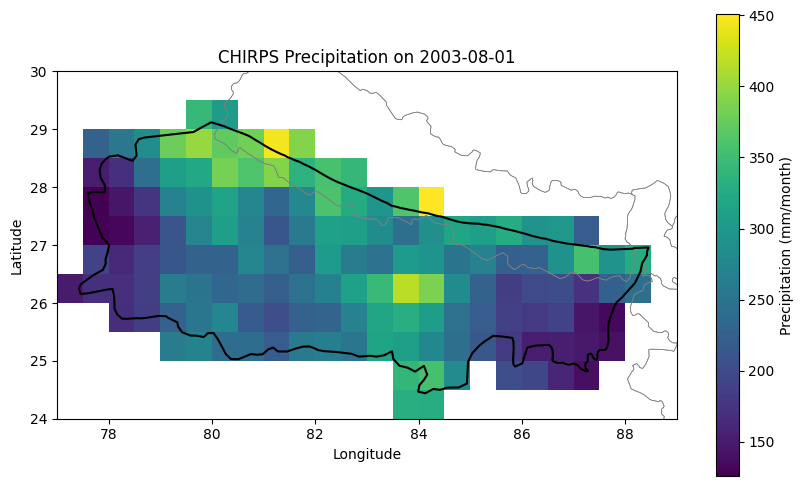

In [ ]:
# Assuming CHIRPS and nepal_shp are already loaded and processed
CHIRPS = CHIRPS_25.rio.write_crs('epsg:4326')
CHIRPS = CHIRPS.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = CHIRPS.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the CHIRPS precipitation data for the selected time
CHIRPSTR = CHIRPS.precip.isel(time=t).transpose('y', 'x')
CHIRPSTR.plot(ax=ax, cmap='viridis', add_colorbar=True, cbar_kwargs={'label': 'Precipitation (mm/month)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'CHIRPS Precipitation on {time_str}')

plt.show()

In [ ]:
CHIRPS_25 = CHIRPS.drop_vars('spatial_ref')
df_pr = CHIRPS_25['precip'].to_dataframe().reset_index()
df_pr = df_pr.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/TRAINING/CHIRPS.csv'
df_pr.to_csv(output_csv_path, index=False)
df_pr

,time,y,x,precip
0,2003-01-01,24.25,77.25,NaN
23,2003-01-01,24.75,77.25,NaN
46,2003-01-01,25.25,77.25,NaN
69,2003-01-01,25.75,77.25,NaN
92,2003-01-01,26.25,77.25,6.679886
...,...,...,...,...
54555,2020-12-01,27.25,88.25,NaN
54578,2020-12-01,27.75,88.25,NaN
54601,2020-12-01,28.25,88.25,NaN
54624,2020-12-01,28.75,88.25,NaN


## NDVI and EVI

In [ ]:
MOD = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/MOD13A3.061_1km_aid0001.nc')
          .rename({'lat': 'y', 'lon': 'x'})
          .rio.write_crs('epsg:4326')
          .sel(time=slice('2003-01-01', '2020-12-31'))
          .rename_vars({'_1_km_monthly_NDVI': 'NDVI'})
          .rename_vars({'_1_km_monthly_EVI': 'EVI'})
          .drop_vars('crs'))
MOD

<xarray.Dataset> Size: 5GB
Dimensions:                   (time: 216, y: 727, x: 1427)
Coordinates:
  * time                      (time) object 2kB 2003-01-01 00:00:00 ... 2020-...
  * y                         (y) float64 6kB 29.81 29.8 29.8 ... 23.77 23.76
  * x                         (x) float64 11kB 77.0 77.0 77.01 ... 88.87 88.88
Data variables:
    EVI                       (time, y, x) float64 2GB ...
    NDVI                      (time, y, x) float64 2GB ...
    _1_km_monthly_VI_Quality  (time, y, x) float64 2GB ...
Attributes:
    title:        MOD13A3.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.84
    references:   See README.md
    history:      See README.md

<ipython-input-107-91c24d39bec0>:2: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  MOD = MOD.rio.set_crs('epsg:4326')


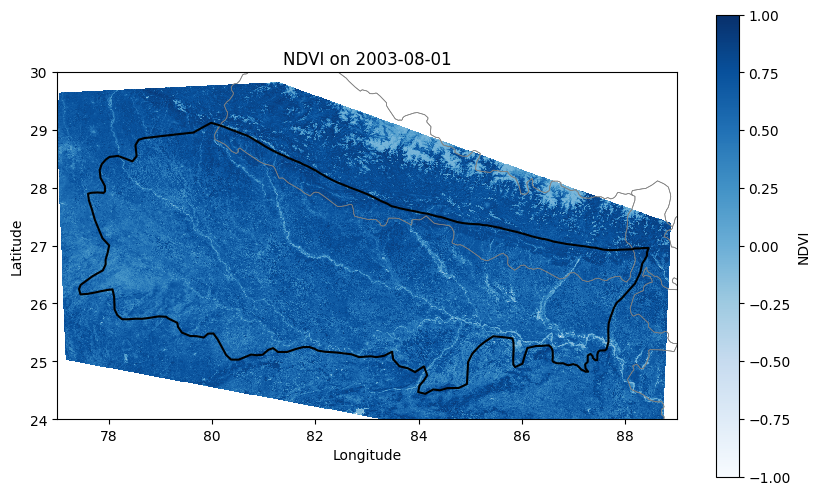

In [ ]:
# Assuming MOD and nepal_shp are already loaded and processed
MOD = MOD.rio.set_crs('epsg:4326')
#MOD = MOD.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = MOD.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the MOD NDVIitation data for the selected time
MODTR = MOD.NDVI.isel(time=t).transpose('y', 'x')
MODTR.plot(ax=ax, cmap='Blues', add_colorbar=True, cbar_kwargs={'label': 'NDVI'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'NDVI on {time_str}')

plt.show()

In [ ]:
regrid_lat = np.arange(24.25, 29.75, 0.5)
regrid_lon = np.arange(77.25, 88.75, 0.5)
MOD_25 = MOD.interp(x=regrid_lon, y=regrid_lat, method='slinear')

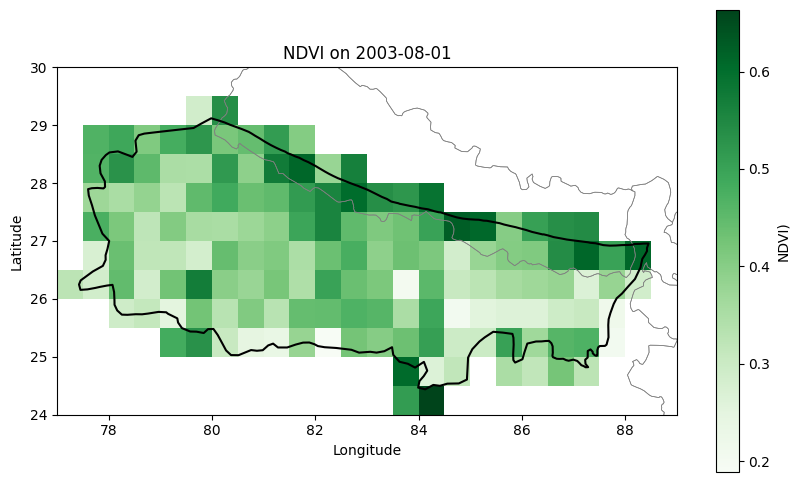

In [ ]:
# Assuming MOD and nepal_shp are already loaded and processed
MOD = MOD_25.rio.write_crs('epsg:4326')
MOD = MOD.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = MOD.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the MOD NDVIitation data for the selected time
MODTR = MOD.EVI.isel(time=t).transpose('y', 'x')
MODTR.plot(ax=ax, cmap='Greens', add_colorbar=True, cbar_kwargs={'label': 'NDVI)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'NDVI on {time_str}')

plt.show()

In [ ]:
MOD = MOD.drop_vars('spatial_ref')
df_pr = MOD[['NDVI','EVI']].to_dataframe().reset_index()
df_pr = df_pr.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/TRAINING/NDVI.csv'
df_pr.to_csv(output_csv_path, index=False)
df_pr

,time,y,x,NDVI,EVI,spatial_ref,crs
0,2003-01-01 00:00:00,24.25,77.25,NaN,NaN,0,0
23,2003-01-01 00:00:00,24.75,77.25,NaN,NaN,0,0
46,2003-01-01 00:00:00,25.25,77.25,NaN,NaN,0,0
69,2003-01-01 00:00:00,25.75,77.25,NaN,NaN,0,0
92,2003-01-01 00:00:00,26.25,77.25,0.23835,0.13775,0,0
...,...,...,...,...,...,...,...
54555,2020-12-01 00:00:00,27.25,88.25,NaN,NaN,0,0
54578,2020-12-01 00:00:00,27.75,88.25,NaN,NaN,0,0
54601,2020-12-01 00:00:00,28.25,88.25,NaN,NaN,0,0
54624,2020-12-01 00:00:00,28.75,88.25,NaN,NaN,0,0



## LST

In [ ]:
LST = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/LST.nc')
          .sel(time=slice('2003-01-01', '2020-12-31'))
          .drop_vars('band')
          .drop_vars('spatial_ref'))
LST

<xarray.Dataset> Size: 5GB
Dimensions:    (x: 1677, y: 859, time: 216)
Coordinates:
  * x          (x) float64 13kB 77.0 77.01 77.02 77.02 ... 88.98 88.99 89.0
  * y          (y) float64 7kB 30.14 30.13 30.12 30.12 ... 24.02 24.01 24.0 24.0
  * time       (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    lst_day    (time, y, x) float64 2GB ...
    lst_night  (time, y, x) float64 2GB ...

In [ ]:
LST['lst_day'] = LST['lst_day']*0.1
LST['lst_night'] = LST['lst_night']*0.1
LST


<xarray.Dataset> Size: 5GB
Dimensions:    (x: 1677, y: 859, time: 216)
Coordinates:
  * x          (x) float64 13kB 77.0 77.01 77.02 77.02 ... 88.98 88.99 89.0
  * y          (y) float64 7kB 30.14 30.13 30.12 30.12 ... 24.02 24.01 24.0 24.0
  * time       (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    lst_day    (time, y, x) float64 2GB nan nan nan nan nan ... nan nan nan nan
    lst_night  (time, y, x) float64 2GB nan nan nan nan nan ... nan nan nan nan

In [ ]:
output_file_path = '/content/drive/MyDrive/Paperwork/DATA/LST_scaled.nc'

# Export the dataset to a NetCDF file
LST.to_netcdf(output_file_path)

<ipython-input-8-729b71d7d94b>:2: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  LST = LST.rio.set_crs('epsg:4326')


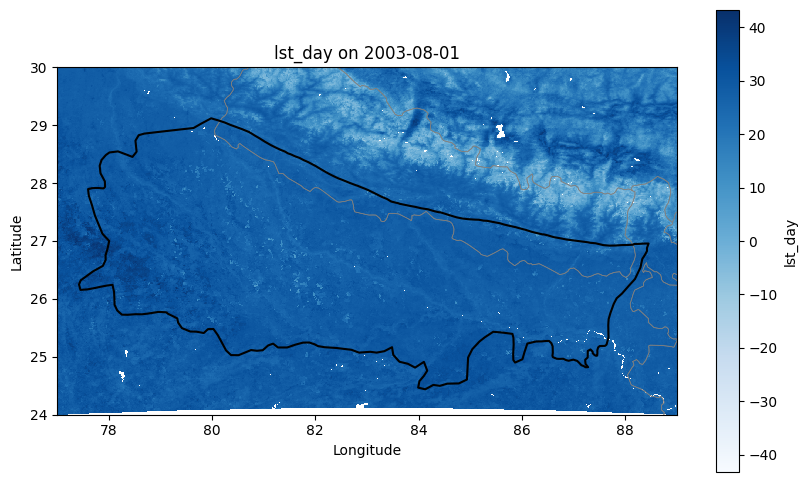

In [ ]:
# Assuming LST and nepal_shp are already loaded and processed
LST = LST.rio.set_crs('epsg:4326')
#LST = LST.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = LST.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the LST lst_dayitation data for the selected time
LSTTR = LST.lst_day.isel(time=t).transpose('y', 'x')
LSTTR.plot(ax=ax, cmap='Blues', add_colorbar=True, cbar_kwargs={'label': 'lst_day'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'lst_day on {time_str}')

plt.show()

In [ ]:
# Assuming your LST dataset is large, open it with chunks
LST_chunked = xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/LST.nc', chunks={'time': 12}) # Adjust chunk size as needed

    # Apply scaling (still on the chunked data)
LST_chunked['lst_day'] = LST_chunked['lst_day'] * 0.1
LST_chunked['lst_night'] = LST_chunked['lst_night'] * 0.1

    # Define regridding coordinates
regrid_lat = np.arange(24.25, 29.75, 0.5)
regrid_lon = np.arange(77.25, 88.75, 0.5)

    # Perform interpolation. Dask will handle processing in chunks.
LST_25 = LST_chunked.interp(x=regrid_lon, y=regrid_lat, method='slinear')

    # Save the chunked result (this will also trigger computation)
LST_25.to_netcdf('/content/drive/MyDrive/Paperwork/DATA/LST_25.nc')

In [ ]:
#IF CHUNKING NOT REQUIRED
#regrid_lat = np.arange(24.25, 29.75, 0.5)
#regrid_lon = np.arange(77.25, 88.75, 0.5)
#LST_25 = LST.interp(x=regrid_lon, y=regrid_lat, method='slinear')

KeyboardInterrupt: 

In [ ]:
LST_25 = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/LST_25.nc')
          .rio.write_crs('epsg:4326').rio.clip(nepal_shp.geometry, all_touched=True))
LST_25 = LST_25.drop_vars('spatial_ref')
df_lst = LST_25[['lst_day','lst_night']].to_dataframe().reset_index()
df_lst = df_lst.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/TRAINING/LST.csv'
df_lst.to_csv(output_csv_path, index=False)
df_lst

,time,y,x,lst_day,lst_night,band
0,2003-01-01,24.25,77.25,NaN,NaN,1
23,2003-01-01,24.75,77.25,NaN,NaN,1
46,2003-01-01,25.25,77.25,NaN,NaN,1
69,2003-01-01,25.75,77.25,NaN,NaN,1
92,2003-01-01,26.25,77.25,27.01938,6.345727,1
...,...,...,...,...,...,...
54555,2020-12-01,27.25,88.25,NaN,NaN,1
54578,2020-12-01,27.75,88.25,NaN,NaN,1
54601,2020-12-01,28.25,88.25,NaN,NaN,1
54624,2020-12-01,28.75,88.25,NaN,NaN,1


## Population Density

In [ ]:
file_path = "/content/drive/MyDrive/Thesis/RAW/LANDSCAN_combined_interpolated.nc"
ds = xr.open_dataset(file_path)
ds = ds.reindex(y=np.sort(ds["y"].values))
# Select the population variable (adjust variable name if different)
pop_data = ds["population"]  # Shape: (time, lat, lon)

# Downscale to 0.5
pop_aggregated = pop_data.coarsen(x=60, y=60, boundary="trim").sum()
#downscale to 0.1 degree
#pop_aggregated = pop_data.coarsen(x=12, y=12, boundary="trim").sum()
pop_aggregated

<xarray.DataArray 'population' (time: 241, y: 12, x: 24)> Size: 555kB
array([[[4.6187200e+05, 3.6859800e+05, 5.7577600e+05, ...,
         1.2025150e+06, 2.3578550e+06, 2.9077450e+06],
        [4.5338300e+05, 3.8459400e+05, 6.8723100e+05, ...,
         1.8154800e+06, 2.3665290e+06, 2.4434980e+06],
        [2.2917500e+05, 5.1424700e+05, 4.0185400e+05, ...,
         2.0910000e+06, 2.5181570e+06, 1.7476090e+06],
        ...,
        [1.6356022e+07, 2.7759140e+06, 2.1847530e+06, ...,
         1.6102000e+04, 5.0820000e+03, 2.1570000e+04],
        [2.2717740e+06, 3.0663660e+06, 2.2838930e+06, ...,
         3.2337000e+04, 2.4654000e+04, 8.7987000e+04],
        [1.8603440e+06, 2.2652590e+06, 2.0100460e+06, ...,
         6.6160000e+03, 1.0618000e+04, 5.7670000e+03]],

       [[4.6310300e+05, 3.6909500e+05, 5.7543500e+05, ...,
         1.2043540e+06, 2.3586150e+06, 2.9131690e+06],
        [4.5477700e+05, 3.8644000e+05, 6.8669300e+05, ...,
         1.8167600e+06, 2.3744430e+06, 2.4432580e+06],
        [2.2916300e+05, 5.1763500e+05, 4.0259200e+05, ...,
         2.0932130e+06, 2.5171150e+06, 1.7514640e+06],
...
        [2.4686587e+07, 4.8491460e+06, 2.6894650e+06, ...,
         1.7065000e+04, 1.0076000e+04, 1.8151000e+04],
        [2.6986640e+06, 3.8591270e+06, 2.7896530e+06, ...,
         4.0183000e+04, 4.0404000e+04, 1.1648600e+05],
        [2.5723500e+06, 3.7216580e+06, 2.2390210e+06, ...,
         8.1660000e+03, 7.8730000e+03, 6.6070000e+03]],

       [[5.9598700e+05, 5.4327900e+05, 7.2442600e+05, ...,
         2.0726690e+06, 3.3579950e+06, 3.3663770e+06],
        [7.4098800e+05, 6.5444100e+05, 8.1071200e+05, ...,
         2.0765970e+06, 3.1052530e+06, 2.7852480e+06],
        [3.4201000e+05, 7.0409000e+05, 5.8527900e+05, ...,
         2.5843990e+06, 3.4627270e+06, 2.3073810e+06],
        ...,
        [2.4692234e+07, 4.8509200e+06, 2.6936030e+06, ...,
         1.7267000e+04, 9.8550000e+03, 1.7381000e+04],
        [2.7022150e+06, 3.8608010e+06, 2.7877870e+06, ...,
         4.0247000e+04, 4.0842000e+04, 1.1625100e+05],
        [2.5728900e+06, 3.7219340e+06, 2.2386650e+06, ...,
         8.3060000e+03, 7.7180000e+03, 6.7550000e+03]]])
Coordinates:
  * x        (x) float64 192B 77.24 77.74 78.24 78.74 ... 87.74 88.24 88.74
  * y        (y) float64 96B 24.25 24.75 25.25 25.75 ... 28.25 28.75 29.25 29.75
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2023-01-01
    band     int64 8B ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      b1
    grid_mapping:   spatial_ref

In [ ]:
#pop_density = pop_aggregated / (27.82987269831839*27.82987269831839) #for calculating density at 0.25
pop_density = pop_aggregated / (55.6597453966366**2) #for calculating density at 0.5
pop_density = pop_density.astype(int)  # Convert to integer
pop_density = pop_density.where(pop_density > 0, np.nan)
pop_density.name = "population_density"
pop_density

<xarray.DataArray 'population_density' (time: 241, y: 12, x: 24)> Size: 555kB
array([[[1.490e+02, 1.180e+02, 1.850e+02, ..., 3.880e+02, 7.610e+02,
         9.380e+02],
        [1.460e+02, 1.240e+02, 2.210e+02, ..., 5.860e+02, 7.630e+02,
         7.880e+02],
        [7.300e+01, 1.650e+02, 1.290e+02, ..., 6.740e+02, 8.120e+02,
         5.640e+02],
        ...,
        [5.279e+03, 8.960e+02, 7.050e+02, ..., 5.000e+00, 1.000e+00,
         6.000e+00],
        [7.330e+02, 9.890e+02, 7.370e+02, ..., 1.000e+01, 7.000e+00,
         2.800e+01],
        [6.000e+02, 7.310e+02, 6.480e+02, ..., 2.000e+00, 3.000e+00,
         1.000e+00]],

       [[1.490e+02, 1.190e+02, 1.850e+02, ..., 3.880e+02, 7.610e+02,
         9.400e+02],
        [1.460e+02, 1.240e+02, 2.210e+02, ..., 5.860e+02, 7.660e+02,
         7.880e+02],
        [7.300e+01, 1.670e+02, 1.290e+02, ..., 6.750e+02, 8.120e+02,
         5.650e+02],
...
        [7.968e+03, 1.565e+03, 8.680e+02, ..., 5.000e+00, 3.000e+00,
         5.000e+00],
        [8.710e+02, 1.245e+03, 9.000e+02, ..., 1.200e+01, 1.300e+01,
         3.700e+01],
        [8.300e+02, 1.201e+03, 7.220e+02, ..., 2.000e+00, 2.000e+00,
         2.000e+00]],

       [[1.920e+02, 1.750e+02, 2.330e+02, ..., 6.690e+02, 1.083e+03,
         1.086e+03],
        [2.390e+02, 2.110e+02, 2.610e+02, ..., 6.700e+02, 1.002e+03,
         8.990e+02],
        [1.100e+02, 2.270e+02, 1.880e+02, ..., 8.340e+02, 1.117e+03,
         7.440e+02],
        ...,
        [7.970e+03, 1.565e+03, 8.690e+02, ..., 5.000e+00, 3.000e+00,
         5.000e+00],
        [8.720e+02, 1.246e+03, 8.990e+02, ..., 1.200e+01, 1.300e+01,
         3.700e+01],
        [8.300e+02, 1.201e+03, 7.220e+02, ..., 2.000e+00, 2.000e+00,
         2.000e+00]]])
Coordinates:
  * x        (x) float64 192B 77.24 77.74 78.24 78.74 ... 87.74 88.24 88.74
  * y        (y) float64 96B 24.25 24.75 25.25 25.75 ... 28.25 28.75 29.25 29.75
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2023-01-01
    band     int64 8B 1

In [ ]:
#shift_x = 0.008333333
#x = pop_density.coords['x']+shift_x
#pop_density.coords['x'] = x

# Export to NetCDF with projection 4326
#output_file = "/content/drive/MyDrive/Thesis/REGRID/LANDSCAN_density_0.25.nc"
output_file = "/content/drive/MyDrive/Paperwork/DATA/0.5/LANDSCAN_density_0.5.nc"
pop_density = pop_density.rio.write_crs("EPSG:4326", inplace=True)  # Set projection
pop_density.to_netcdf(output_file)
pop_density

<xarray.DataArray 'population_density' (time: 241, y: 12, x: 24)> Size: 555kB
array([[[1.490e+02, 1.180e+02, 1.850e+02, ..., 3.880e+02, 7.610e+02,
         9.380e+02],
        [1.460e+02, 1.240e+02, 2.210e+02, ..., 5.860e+02, 7.630e+02,
         7.880e+02],
        [7.300e+01, 1.650e+02, 1.290e+02, ..., 6.740e+02, 8.120e+02,
         5.640e+02],
        ...,
        [5.279e+03, 8.960e+02, 7.050e+02, ..., 5.000e+00, 1.000e+00,
         6.000e+00],
        [7.330e+02, 9.890e+02, 7.370e+02, ..., 1.000e+01, 7.000e+00,
         2.800e+01],
        [6.000e+02, 7.310e+02, 6.480e+02, ..., 2.000e+00, 3.000e+00,
         1.000e+00]],

       [[1.490e+02, 1.190e+02, 1.850e+02, ..., 3.880e+02, 7.610e+02,
         9.400e+02],
        [1.460e+02, 1.240e+02, 2.210e+02, ..., 5.860e+02, 7.660e+02,
         7.880e+02],
        [7.300e+01, 1.670e+02, 1.290e+02, ..., 6.750e+02, 8.120e+02,
         5.650e+02],
...
        [7.968e+03, 1.565e+03, 8.680e+02, ..., 5.000e+00, 3.000e+00,
         5.000e+00],
        [8.710e+02, 1.245e+03, 9.000e+02, ..., 1.200e+01, 1.300e+01,
         3.700e+01],
        [8.300e+02, 1.201e+03, 7.220e+02, ..., 2.000e+00, 2.000e+00,
         2.000e+00]],

       [[1.920e+02, 1.750e+02, 2.330e+02, ..., 6.690e+02, 1.083e+03,
         1.086e+03],
        [2.390e+02, 2.110e+02, 2.610e+02, ..., 6.700e+02, 1.002e+03,
         8.990e+02],
        [1.100e+02, 2.270e+02, 1.880e+02, ..., 8.340e+02, 1.117e+03,
         7.440e+02],
        ...,
        [7.970e+03, 1.565e+03, 8.690e+02, ..., 5.000e+00, 3.000e+00,
         5.000e+00],
        [8.720e+02, 1.246e+03, 8.990e+02, ..., 1.200e+01, 1.300e+01,
         3.700e+01],
        [8.300e+02, 1.201e+03, 7.220e+02, ..., 2.000e+00, 2.000e+00,
         2.000e+00]]])
Coordinates:
  * x            (x) float64 192B 77.24 77.74 78.24 78.74 ... 87.74 88.24 88.74
  * y            (y) float64 96B 24.25 24.75 25.25 25.75 ... 28.75 29.25 29.75
  * time         (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2023-01-01
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [ ]:
pop_density = xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/0.5/LANDSCAN_density_0.5.nc')
pop_density = pop_density.rio.write_crs('epsg:4326')
pop_density = pop_density.rio.clip(nepal_shp.geometry, all_touched=True)
pop_density = pop_density.sel(time=slice('2003-01-01', '2020-12-31'))

In [ ]:
pop_density

<xarray.Dataset> Size: 439kB
Dimensions:             (x: 23, y: 11, time: 216)
Coordinates:
  * x                   (x) float64 184B 77.24 77.74 78.24 ... 87.24 87.74 88.24
  * y                   (y) float64 88B 24.25 24.75 25.25 ... 28.25 28.75 29.25
  * time                (time) datetime64[ns] 2kB 2003-01-01 ... 2020-12-01
    band                int64 8B ...
    spatial_ref         int64 8B 0
Data variables:
    population_density  (time, y, x) float64 437kB nan nan nan ... nan nan nan

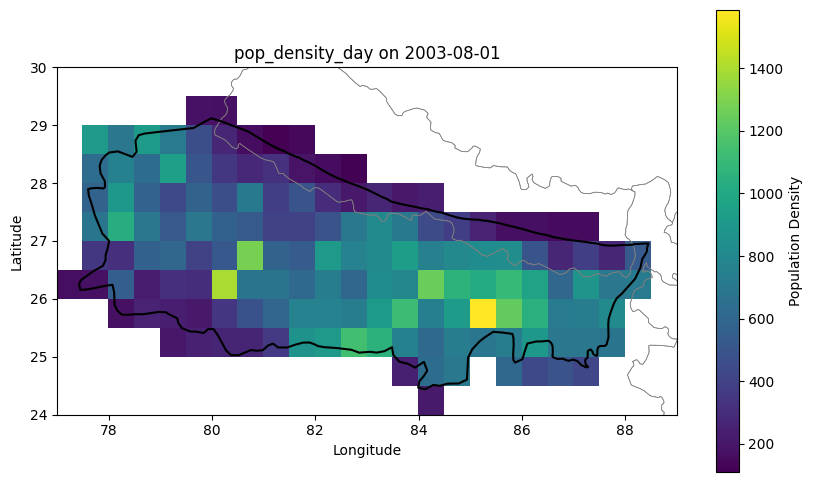

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = pop_density.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the pop_density pop_density_dayitation data for the selected time
pop_densityTR = pop_density.isel(time=t).transpose('y', 'x')
pop_densityTR['population_density'].plot.imshow(ax=ax, cmap='viridis', add_colorbar=True, cbar_kwargs={'label': 'Population Density'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'pop_density_day on {time_str}')

plt.show()

In [ ]:
#pop_density = pop_density.drop_vars(['spatial_ref','band'])
df_pop = pop_density.to_dataframe().reset_index()
df_pop = df_pop.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/TRAINING/population.csv'
df_pop.to_csv(output_csv_path, index=False)
df_pop

,x,y,time,band,spatial_ref,population_density
0,77.241667,24.25,2003-01-01,1,0,NaN
216,77.241667,24.75,2003-01-01,1,0,NaN
432,77.241667,25.25,2003-01-01,1,0,NaN
648,77.241667,25.75,2003-01-01,1,0,NaN
864,77.241667,26.25,2003-01-01,1,0,166.0
...,...,...,...,...,...,...
53783,88.241667,27.25,2020-12-01,1,0,NaN
53999,88.241667,27.75,2020-12-01,1,0,NaN
54215,88.241667,28.25,2020-12-01,1,0,NaN
54431,88.241667,28.75,2020-12-01,1,0,NaN


## Topo Variables

### Elevation

In [ ]:
dem_file = "/content/drive/MyDrive/Paperwork/DATA/DEM_0.5.tif"
dem = rioxarray.open_rasterio(dem_file)
dem = dem.squeeze(dim="band", drop=True)
dem = dem.rio.clip(nepal_shp.geometry,all_touched= True)
dem

<xarray.DataArray (y: 11, x: 23)> Size: 506B
array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  247,  246,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  456,  118,  139,    0,  125,  315,  224,  128,    0,
           0],
       [   0,    0,    0,    0,  222,  204,  156,  135,  131,  157,   92,
          71,   81,   72,   84,   79,   65,   54,   49,   46,   34,  159,
           0],
       [   0,    0,  248,  198,  168,  149,  125,   88,  113,  108,   98,
          91,   78,   73,   61,   57,   53,   51,   49,   39,   41,   38,
           0],
       [ 173,  194,  266,  175,  136,  139,  125,  105,  117,  110,   96,
          94,   85,   64,   68,   69,   62,   59,   60,   58,   63,   55,
          57],
       [   0,  201,  138,  142,  151,  142,  136,  133,  115,  102,  101,
          88,   83,   84,   81,   76,   71,   70,   81,  158,   96,  226,
         232],
       [   0,  175,  172,  165,  154,  149,  139,  129,  125,  109,  106,
          94,   89,   93,   99,  104,  224,  302, 1060,  631, 2037,    0,
           0],
       [   0,  186,  182,  177,  156,  146,  148,  142,  126,  129,  127,
         684,  173,  895,  885,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,  198,  193,  180,  175,  165,  167,  154,  134,  158, 1081,
        1138,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,  213,  212,  206,  186,  191,  211,  196,  273, 1467,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0,    0,  595, 1201,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int16)
Coordinates:
  * x            (x) float64 184B 77.25 77.75 78.25 78.75 ... 87.25 87.75 88.25
  * y            (y) float64 88B 24.25 24.75 25.25 25.75 ... 28.25 28.75 29.25
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

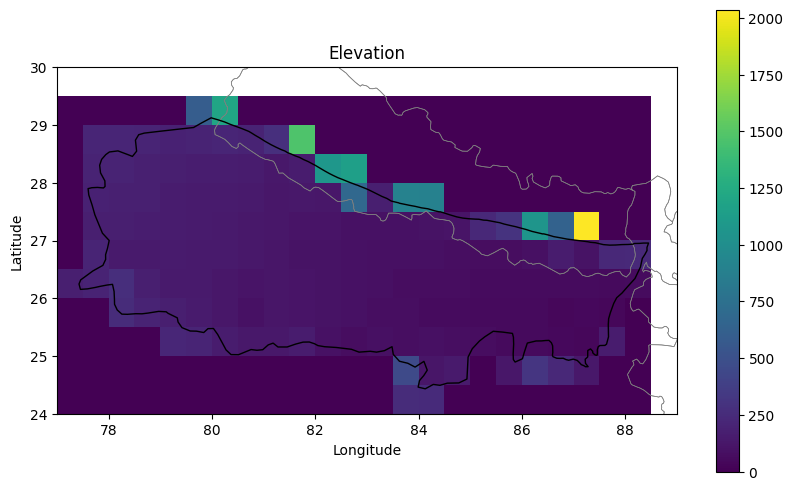

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fill_value = -32768
dem_masked = dem.where(dem != fill_value)
dem_tr = dem_masked.transpose('y', 'x')
dem_tr.plot(ax=ax)
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')
# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'Elevation')
plt.show()

In [ ]:
dem.name = "elevation"
demdf = dem.to_dataframe().reset_index()
demdf = demdf.sort_values(by=['x','y'])
demdf
# Export to CSV
demdf.to_csv('/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/DEM/elevation.csv', index=False)
demdf

,y,x,spatial_ref,elevation
0,24.25,77.25,0,0
23,24.75,77.25,0,0
46,25.25,77.25,0,0
69,25.75,77.25,0,0
92,26.25,77.25,0,173
...,...,...,...,...
160,27.25,88.25,0,0
183,27.75,88.25,0,0
206,28.25,88.25,0,0
229,28.75,88.25,0,0


### Slope

In [ ]:
slope_file = "/content/drive/MyDrive/Paperwork/DATA/0.5/SLOPE_0.5.tif"
slope = rioxarray.open_rasterio(slope_file)
slope = slope.squeeze(dim="band", drop=True)
slope = slope.rio.clip(nepal_shp.geometry,all_touched= True)
slope

<xarray.DataArray (y: 11, x: 23)> Size: 1kB
array([[-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03,  8.12499002e-02,  1.47481754e-01,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03,  1.12134188e-01,  1.18758522e-01,
         1.26981810e-01, -9.99900000e+03,  1.67258278e-01,
         1.32968202e-01,  1.22959554e-01,  6.11877292e-02,
        -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03,  9.21017528e-02,  1.00800790e-01,
         1.08759493e-01,  1.18678324e-01,  1.09319068e-01,
         1.12285234e-01,  1.26202911e-01,  1.14962757e-01,
...
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03,  1.55340116e-02,  1.68791972e-02,
         2.40773354e-02,  8.90891775e-02,  2.83809394e-01,
         6.36643410e-01,  8.99145484e-01,  1.13154757e+00,
         1.22040772e+00, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03,  7.23001540e-01,
         8.87706161e-01, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03]], dtype=float32)
Coordinates:
  * x            (x) float64 184B 77.25 77.75 78.25 78.75 ... 87.25 87.75 88.25
  * y            (y) float64 88B 24.25 24.75 25.25 25.75 ... 28.25 28.75 29.25
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

In [ ]:
slope.name = "slope"
slopedf = slope.to_dataframe().reset_index()
slopedf = slopedf.sort_values(by=['x','y'])
slopedf
# Export to CSV
slopedf.to_csv('/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/DEM/slope.csv', index=False)
slopedf

,y,x,spatial_ref,slope
0,24.25,77.25,0,-9999.000000
23,24.75,77.25,0,-9999.000000
46,25.25,77.25,0,-9999.000000
69,25.75,77.25,0,-9999.000000
92,26.25,77.25,0,0.071327
...,...,...,...,...
160,27.25,88.25,0,-9999.000000
183,27.75,88.25,0,-9999.000000
206,28.25,88.25,0,-9999.000000
229,28.75,88.25,0,-9999.000000


In [ ]:
aspect_file = "/content/drive/MyDrive/Paperwork/DATA/0.5/ASPECT_0.5.tif"
aspect = rioxarray.open_rasterio(aspect_file)
aspect = aspect.squeeze(dim="band", drop=True)
aspect = aspect.rio.clip(nepal_shp.geometry,all_touched= True)
aspect

<xarray.DataArray (y: 11, x: 23)> Size: 1kB
array([[-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03,  1.57422089e+02,  1.66607513e+02,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03,  1.49691406e+02,  1.41699554e+02,
         1.89347580e+02, -9.99900000e+03,  1.90928894e+02,
         1.83112045e+02,  1.49159851e+02,  1.90315643e+02,
        -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03,  1.70168549e+02,  1.63048096e+02,
         1.68237244e+02,  1.75639481e+02,  1.80675629e+02,
         1.79276443e+02,  1.67014160e+02,  1.72396866e+02,
...
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03,  9.07149506e+00,  1.73279190e+01,
         1.29946136e+01,  3.32137207e+02,  3.32957794e+02,
         3.39892029e+02,  3.54612244e+02,  3.38707581e+02,
         3.35118347e+02, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03,  3.39503723e+02,
         3.25901520e+02, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
        -9.99900000e+03, -9.99900000e+03]], dtype=float32)
Coordinates:
  * x            (x) float64 184B 77.25 77.75 78.25 78.75 ... 87.25 87.75 88.25
  * y            (y) float64 88B 24.25 24.75 25.25 25.75 ... 28.25 28.75 29.25
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

In [ ]:
aspect.name = "aspect"
aspectdf = aspect.to_dataframe().reset_index()
aspectdf = aspectdf.sort_values(by=['x','y'])
aspectdf
# Export to CSV
aspectdf.to_csv('/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/DEM/aspect.csv', index=False)
aspectdf

,y,x,spatial_ref,aspect
0,24.25,77.25,0,-9999.000000
23,24.75,77.25,0,-9999.000000
46,25.25,77.25,0,-9999.000000
69,25.75,77.25,0,-9999.000000
92,26.25,77.25,0,181.967804
...,...,...,...,...
160,27.25,88.25,0,-9999.000000
183,27.75,88.25,0,-9999.000000
206,28.25,88.25,0,-9999.000000
229,28.75,88.25,0,-9999.000000


In [ ]:
import pandas as pd
import os

# Folder containing the CSV files
input_folder = f'/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/DEM'
output_folder = f'/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Step 2: Create a date range from 2003-02-01 to 2016-12-31 (monthly frequency)
date_range = pd.date_range(start='2003-01-01', end='2020-12-31', freq='MS')
# Loop through each CSV file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        # Step 1: Read each original CSV file
        file_path = os.path.join(input_folder, file_name)
        original_data = pd.read_csv(file_path)

        # Step 5: Repeat the original data for each valid date (excluding the missing ones)
        extended_data = pd.concat([original_data] * len(date_range), ignore_index=True)
        extended_data['time'] = date_range.repeat(len(original_data)).values

        # Step 6: Export the new data with the time dimension to a new CSV file
        output_file = os.path.join(output_folder, f'extended_{file_name}')
        extended_data.to_csv(output_file, index=False)

        print(f"Processed and saved {output_file}")

print("All files have been processed and saved.")

Processed and saved /content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/extended_elevation.csv
Processed and saved /content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/extended_slope.csv
Processed and saved /content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/extended_aspect.csv
All files have been processed and saved.


# Check and Combine

In [ ]:
import os
import pandas as pd

# Path to the folder containing the CSV files
folder_path = f'/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S'

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Print the file name and the number of rows
        print(f'File: {filename}, Number of rows: {len(df)}')

File: GWSA.csv, Number of rows: 54648
File: LST.csv, Number of rows: 54648
File: NDVI.csv, Number of rows: 54648
File: population.csv, Number of rows: 54648
File: IMERG.csv, Number of rows: 54648
File: RFM_training.csv, Number of rows: 54648
File: extended_elevation.csv, Number of rows: 54648
File: extended_slope.csv, Number of rows: 54648
File: extended_aspect.csv, Number of rows: 54648


In [ ]:
import os
import pandas as pd

# Specify the folder containing the CSV files
folder_path = '/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Loop through each CSV file and display its first few rows
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    try:
        df = pd.read_csv(file_path)  # Read the CSV file
        print(f"Preview of {file}:")
        print(df.head())  # Display first 5 rows
        print("\n" + "-"*50 + "\n")  # Separator for better readability
    except Exception as e:
        print(f"Could not read {file}: {e}")

Preview of GWSA.csv:
         time      y      x        gwsa
0  2003-01-01  24.25  77.25         NaN
1  2003-01-01  24.75  77.25         NaN
2  2003-01-01  25.25  77.25         NaN
3  2003-01-01  25.75  77.25         NaN
4  2003-01-01  26.25  77.25  146.796998

--------------------------------------------------

Preview of LST.csv:
         time      y      x   lst_day  lst_night  band
0  2003-01-01  24.25  77.25       NaN        NaN     1
1  2003-01-01  24.75  77.25       NaN        NaN     1
2  2003-01-01  25.25  77.25       NaN        NaN     1
3  2003-01-01  25.75  77.25       NaN        NaN     1
4  2003-01-01  26.25  77.25  27.01938   6.345727     1

--------------------------------------------------

Preview of NDVI.csv:
                  time      y      x     NDVI      EVI  spatial_ref  crs
0  2003-01-01 00:00:00  24.25  77.25      NaN      NaN            0    0
1  2003-01-01 00:00:00  24.75  77.25      NaN      NaN            0    0
2  2003-01-01 00:00:00  25.25  77.25      N

In [ ]:
import os
import pandas as pd

# Function to get the columns to copy from each CSV file
def select_columns(df, file_name):
    print(f"Available columns in {file_name}:")
    print(df.columns.tolist())

    # Ask the user for the column names they want to copy
    selected_columns = input("Enter the columns to copy (separated by commas): ").split(",")
    selected_columns = [col.strip() for col in selected_columns]  # Remove leading/trailing spaces
    return df[selected_columns]

# Folder where the CSV files are located
folder_path = f'/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ask the user which columns to copy
        selected_data = select_columns(df, file_name)

        # Add the selected columns to the combined DataFrame
        combined_df = pd.concat([combined_df, selected_data], axis=1)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv(f"/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/RFM_training.csv", index=False)
print("Combined CSV file created")

Available columns in GWSA.csv:
['time', 'y', 'x', 'gwsa']
Enter the columns to copy (separated by commas): time, y, x, gwsa
Available columns in LST.csv:
['time', 'y', 'x', 'lst_day', 'lst_night', 'band']
Enter the columns to copy (separated by commas): lst_day, lst_night
Available columns in NDVI.csv:
['time', 'y', 'x', 'NDVI', 'EVI', 'spatial_ref', 'crs']
Enter the columns to copy (separated by commas): NDVI, EVI
Available columns in population.csv:
['x', 'y', 'time', 'band', 'spatial_ref', 'population_density']
Enter the columns to copy (separated by commas): population_density
Available columns in IMERG.csv:
['time', 'x', 'y', 'precipitation']
Enter the columns to copy (separated by commas): precipitation
Available columns in extended_elevation.csv:
['y', 'x', 'spatial_ref', 'elevation', 'time']
Enter the columns to copy (separated by commas): elevation
Available columns in extended_slope.csv:
['y', 'x', 'spatial_ref', 'slope', 'time']
Enter the columns to copy (separated by commas

In [ ]:
# Define the output path for the NetCDF file
output_nc_file_path = '/content/drive/MyDrive/Paperwork/DATA/0.5/IMERG_0.5.nc'

# Export the IMERG_25 dataset to a NetCDF file
try:
    IMERG_25.to_netcdf(output_nc_file_path)
    print(f"Successfully exported IMERG_25 to {output_nc_file_path}")
except Exception as e:
    print(f"Error exporting IMERG_25 to NetCDF: {e}")